In [1]:
# pip install datasets pillow numpy torch torchvision

from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np, random
from PIL import Image

# ──────────────────────────────────────────────────────────────────────────────
# CONFIG
# ──────────────────────────────────────────────────────────────────────────────
DATA_DIR   = "dataset/celeba_hq"
HR_SIZE    = 256
TRAIN_SR   = (1.0, 8.0)
VAL_SR     = 4.0
ADD_FFT    = True
BATCH_SIZE = 16
# ──────────────────────────────────────────────────────────────────────────────


# ──────────────────────────────────────────────────────────────────────────────
# PREPROCESSING (per‐example)
# ──────────────────────────────────────────────────────────────────────────────
def make_input_and_target(img: Image.Image, sr_factor: float):
    # 1) HR in [0,1]
    hr = img.resize((HR_SIZE, HR_SIZE), Image.BILINEAR)
    hr_arr = np.array(hr, dtype=np.float32) / 255.0  # H,W,3

    # 2) downsample & upsample
    lr = hr.resize((int(HR_SIZE/sr_factor), int(HR_SIZE/sr_factor)),
                   Image.BILINEAR)
    lr_up = lr.resize((HR_SIZE, HR_SIZE), Image.BILINEAR)
    inp_arr = np.array(lr_up, dtype=np.float32) / 255.0  # H,W,3

    # 3) optional FFT channels
    if ADD_FFT:
        fft_feats = []
        for c in range(3):
            f = np.fft.fft2(inp_arr[..., c])
            fft_feats.append(np.real(f))
            fft_feats.append(np.imag(f))
        fft_arr = np.stack(fft_feats, axis=-1)  # H,W,6
        inp_arr = np.concatenate([inp_arr, fft_arr], axis=-1)  # H,W,9

    # 4) to CHW
    inp = np.transpose(inp_arr, (2,0,1))
    hr  = np.transpose(hr_arr,  (2,0,1))
    return inp, hr


def preprocess_stream(example, *, is_train: bool):
    # example["image"] is a PIL image
    if is_train:
        r = random.uniform(*TRAIN_SR)
    else:
        r = VAL_SR

    inp, hr = make_input_and_target(example["image"], sr_factor=r)
    return {"inp": inp, "hr": hr}


# ──────────────────────────────────────────────────────────────────────────────
# 1) LOAD AS STREAMING DATASETS
# ──────────────────────────────────────────────────────────────────────────────
train_ds = load_dataset(
    "imagefolder",
    data_dir=f"{DATA_DIR}/train",
    split="train",
    streaming=True,
) # -> Returns a dictionary with two keys 'inp', 'hr'
val_ds = load_dataset(
    "imagefolder",
    data_dir=f"{DATA_DIR}/val",
    split="train",
    streaming=True,
)

# ──────────────────────────────────────────────────────────────────────────────
# 2) SHUFFLE + MAP (single‐example mapping only)
# ──────────────────────────────────────────────────────────────────────────────
# note: num_proc & batched=True are NOT supported in streaming mode!
train_ds = train_ds.shuffle(buffer_size=10_000)            # small in-RAM buffer
train_ds = train_ds.map(lambda ex: preprocess_stream(ex, is_train=True),
                        remove_columns=["image","label"])

val_ds   = val_ds.map(lambda ex: preprocess_stream(ex, is_train=False),
                      remove_columns=["image","label"])


/home/vedant/miniconda3/envs/torch-training/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Resolving data files:   0%|          | 0/28000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

In [2]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) FORMAT FOR PYTORCH
# ──────────────────────────────────────────────────────────────────────────────
train_ds = train_ds.with_format("torch")#, columns=["inp","hr"])
val_ds   = val_ds.with_format("torch")#, columns=["inp","hr"])


# ──────────────────────────────────────────────────────────────────────────────
# 4) DATALOADERS (IterableDataset)
# ──────────────────────────────────────────────────────────────────────────────
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False,           # shuffle was done upstream
    drop_last=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

batch = next(iter(train_loader))
print(batch["inp"].shape, batch["hr"].shape)
# Should output [B, C, W, H], [B, C, W, H]

torch.Size([16, 9, 256, 256]) torch.Size([16, 3, 256, 256])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from transformers import PretrainedConfig, PreTrainedModel

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
class CosAEConfig(PretrainedConfig):
    model_type = "cosae"

    def __init__(
        self,
        image_size: tuple[int, int] = (256, 256),
        # Encoder parameters
        in_channels: int = 3,
        hidden_dims: list[int] = (64, 128, 256, 512),
        num_res_blocks: int = 2,
        downsample_strides: list[int] = (2, 2, 2, 2),
        use_encoder_attention: bool = True,
        encoder_attention_heads: int = 8,
        encoder_attention_layers: int = 1,
        bottleneck_channels: int = 256,
        basis_size: int = 32,
        norm_type: str = "gn",      # "gn" (GroupNorm) or "ln" (LayerNorm)
        activation: str = "gelu",   # "gelu" or "silu"

        # Decoder parameters
        decoder_hidden_dim: int = 256,
        decoder_upsample_strides: list[int] = (2,),  # e.g. (2,) for one 2× upsample
        use_decoder_attention: bool = False,
        decoder_attention_heads: int = 8,
        decoder_attention_layers: int = 0,

        **kwargs,
    ):
        """
        Configuration for CosAEModel, including encoder, HCM, and decoder settings.
        """
        super().__init__(**kwargs)

        # Encoder settings
        self.in_channels = in_channels
        self.hidden_dims = list(hidden_dims)
        self.num_res_blocks = num_res_blocks
        self.downsample_strides = list(downsample_strides)
        self.use_encoder_attention = use_encoder_attention
        self.encoder_attention_heads = encoder_attention_heads
        self.encoder_attention_layers = encoder_attention_layers
        self.bottleneck_channels = bottleneck_channels
        self.basis_size = basis_size
        self.norm_type = norm_type
        self.activation = activation
        self.image_size = image_size
        
        # Decoder settings
        self.decoder_hidden_dim = decoder_hidden_dim
        self.decoder_upsample_strides = list(decoder_upsample_strides)
        self.use_decoder_attention = use_decoder_attention
        self.decoder_attention_heads = decoder_attention_heads
        self.decoder_attention_layers = decoder_attention_layers

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm_type="gn", activation="gelu"):
        super().__init__()
        Norm = nn.GroupNorm if norm_type == "gn" else nn.LayerNorm
        act = nn.GELU if activation == "gelu" else nn.SiLU

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.norm1 = Norm(8, out_ch) if norm_type == "gn" else Norm(out_ch)
        self.act1 = act()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.norm2 = Norm(8, out_ch) if norm_type == "gn" else Norm(out_ch)
        self.act2 = act()

        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = out + identity
        return self.act2(out)

In [6]:
class CosAEEncoder(PreTrainedModel):
    config_class = CosAEConfig
    base_model_prefix = "encoder"

    def __init__(self, config: CosAEConfig):
        super().__init__(config)
        c = config
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(c.in_channels, c.hidden_dims[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.GroupNorm(8, c.hidden_dims[0]) if c.norm_type == "gn" else nn.LayerNorm([c.hidden_dims[0], 128, 128]),
            nn.GELU() if c.activation == "gelu" else nn.SiLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # Downsampling stages
        dims = c.hidden_dims
        self.stages = nn.ModuleList()
        in_ch = dims[0]
        for i, out_ch in enumerate(dims[1:]):
            blocks = []
            for _ in range(c.num_res_blocks):
                blocks.append(ResBlock(in_ch, out_ch, norm_type=c.norm_type, activation=c.activation))
                in_ch = out_ch
            # downsample conv
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=c.downsample_strides[i], padding=1, bias=False),
                    nn.GroupNorm(8, out_ch) if c.norm_type == "gn" else nn.LayerNorm([out_ch, -1, -1]),
                    nn.GELU() if c.activation == "gelu" else nn.SiLU(),
                )
            )
            self.stages.append(nn.Sequential(*blocks))

        # Optional global attention
        if c.use_encoder_attention:
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=dims[-1],
                nhead=c.encoder_attention_heads,
                dim_feedforward=dims[-1] * 4,
                activation=c.activation,
                batch_first=True,
            )
            self.attn = nn.TransformerEncoder(encoder_layer, num_layers=c.encoder_attention_layers)
        else:
            self.attn = None

        # Head: project to 2 * bottleneck_channels
        self.head = nn.Conv2d(dims[-1], 2 * c.bottleneck_channels, kernel_size=1)

        # Initialize weights
        self.post_init()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [B, C_in, H, W]
        Returns:
            bottleneck: [B, 2c, H/P, W/P]
        """
        # Stem
        x = self.stem(x)
        # Stages
        for stage in self.stages:
            x = stage(x)
        # x: [B, dims[-1], H/P, W/P]
        # Optional attention
        if self.attn is not None:
            B, C, H, W = x.shape
            seq = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
            seq = self.attn(seq)
            x = seq.transpose(1, 2).view(B, C, H, W)
        # Head
        bottleneck = self.head(x)
        return bottleneck

In [7]:
class HarmonicConstructionModule(nn.Module):
    """
    Given:
      - amplitudes: Tensor of shape [B, c, H', W']
      - phases:     Tensor of shape [B, c, H', W']
    and learnable frequencies (u, v) of shape [c, 2],
    this module builds a [B, c, H'*T, W'*T] tensor of harmonics:
       H[b,k,i*T + x, j*T + y]
         = A[b,k,i,j] * cos( 2π/T * (u[k]*x + v[k]*y) - Φ[b,k,i,j] )
    """
    def __init__(self, bottleneck_channels: int, basis_size: int):
        """
        Args:
          bottleneck_channels: c, number of freq components
          basis_size:          T, size of each cosine basis (e.g. 32 or 64)
        """
        super().__init__()
        self.c = bottleneck_channels
        self.T = basis_size

        # Learnable frequencies in [0, T/2)
        self.freqs = nn.Parameter(
            torch.rand(self.c, 2) * (self.T / 2)
        )  # shape [c,2] for (u,v)

        # Precompute the x,y grid of size [T, T]
        x = torch.arange(self.T, dtype=torch.float32)
        y = torch.arange(self.T, dtype=torch.float32)
        xs, ys = torch.meshgrid(x, y, indexing="ij")  # both shape [T,T]

        # Register as buffers so they move with .to(device)
        self.register_buffer("xs", xs)  # [T,T]
        self.register_buffer("ys", ys)  # [T,T]

    def forward(self, amplitude: torch.Tensor, phase: torch.Tensor) -> torch.Tensor:
        """
        Args:
          amplitude: [B, c, H', W']
          phase:     [B, c, H', W']
        Returns:
          harmonics: [B, c, H'*T, W'*T]
        """
        B, c, Hp, Wp = amplitude.shape
        assert c == self.c, "Channel mismatch"

        # 1) compute spatial_phase for each freq: [c, T, T]
        #    2π/T * (u[k]*xs + v[k]*ys)
        u = self.freqs[:, 0].view(c, 1, 1)  # [c,1,1]
        v = self.freqs[:, 1].view(c, 1, 1)  # [c,1,1]
        spatial_phase = (2 * math.pi / self.T) * (u * self.xs + v * self.ys)
        # reshape for broadcasting to [1,c,1,1,T,T]
        spatial_phase = spatial_phase.view(1, c, 1, 1, self.T, self.T)

        # 2) prepare amplitude & phase maps:
        #    [B, c, Hp, Wp] → [B, c, Hp, Wp, 1, 1]
        A = amplitude.view(B, c, Hp, Wp, 1, 1)
        Φ = phase.view(B, c, Hp, Wp, 1, 1)

        # 3) compute argument and harmonic:
        #    arg = spatial_phase - Φ
        #    H = A * cos(arg)
        arg = spatial_phase - Φ  # [B, c, Hp, Wp, T, T]
        H = A * torch.cos(arg)   # same shape

        # 4) tile out to full spatial size [B, c, Hp*T, Wp*T]
        #    first permute to [B, c, Hp, T, Wp, T] then reshape
        H = H.permute(0, 1, 2, 4, 3, 5)  # [B, c, Hp, T, Wp, T]
        H = H.reshape(B, c, Hp * self.T, Wp * self.T)

        return H

In [8]:
class CosAEDecoder(PreTrainedModel):
    config_class = CosAEConfig
    base_model_prefix = "decoder"

    def __init__(self, config: CosAEConfig):
        super().__init__(config)
        c = config

        # 1×1 projection from HCM channels → decoder hidden dim
        self.proj = nn.Conv2d(
            c.bottleneck_channels,
            c.decoder_hidden_dim,
            kernel_size=1,
            bias=False
        )
        # normalization + activation after proj
        Norm = nn.GroupNorm if c.norm_type == "gn" else nn.LayerNorm
        self.norm0 = Norm(8, c.decoder_hidden_dim) if c.norm_type=="gn" else Norm([c.decoder_hidden_dim, -1, -1])
        self.act0  = nn.GELU() if c.activation=="gelu" else nn.SiLU()

        # upsampling blocks
        self.upsamples = nn.ModuleList()
        for scale in c.decoder_upsample_strides:
            block = nn.Sequential(
                nn.Upsample(scale_factor=scale, mode="bilinear", align_corners=False),
                nn.Conv2d(c.decoder_hidden_dim, c.decoder_hidden_dim, kernel_size=3, padding=1, bias=False),
                Norm(8, c.decoder_hidden_dim) if c.norm_type=="gn" else Norm([c.decoder_hidden_dim, -1, -1]),
                nn.GELU() if c.activation=="gelu" else nn.SiLU(),
            )
            self.upsamples.append(block)

        # optional global attention in decoder
        if c.use_decoder_attention:
            enc_layer = nn.TransformerEncoderLayer(
                d_model=c.decoder_hidden_dim,
                nhead=c.decoder_attention_heads,
                dim_feedforward=c.decoder_hidden_dim * 4,
                activation=c.activation,
                batch_first=True,
            )
            self.attn = nn.TransformerEncoder(enc_layer, num_layers=c.decoder_attention_layers)
        else:
            self.attn = None

        # final conv to RGB
        self.final_conv = nn.Conv2d(
            c.decoder_hidden_dim,
            3,
            kernel_size=3,
            padding=1
        )

        # initialize weights
        self.post_init()

    def forward(self, harmonics: torch.Tensor) -> torch.Tensor:
        """
        Args:
          harmonics: Tensor from HCM, shape [B, c, H*, W*]
        Returns:
          recon:     Reconstructed image, shape [B, 3, H, W]
        """
        x = self.proj(harmonics)         # [B, hidden_dim, H*, W*]
        x = self.norm0(x)
        x = self.act0(x)

        # upsample to higher resolution
        for up in self.upsamples:
            x = up(x)                   # doubles H*, W* each block

        # optional global attention
        if self.attn is not None:
            B, C, H, W = x.shape
            seq = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
            seq = self.attn(seq)
            x = seq.transpose(1, 2).view(B, C, H, W)

        # final RGB projection
        recon = self.final_conv(x)
        return recon

In [9]:
class CosAEModel(PreTrainedModel):
    config_class = CosAEConfig
    base_model_prefix = "cosae"

    def __init__(self, config: CosAEConfig):
        super().__init__(config)
        # 1) Encoder
        self.encoder = CosAEEncoder(config)

        # 2) Harmonic Construction Module
        #    derive P = total downsampling factor from encoder strides
        stem_ds = 2 * 2
        P       = stem_ds * math.prod(config.downsample_strides)
        #    basis size T = P // 2
        T = P // 2
        self.T = T
        self.hcm = HarmonicConstructionModule(
            bottleneck_channels=config.bottleneck_channels,
            basis_size=config.basis_size
        )

        # 3) Decoder
        self.decoder = CosAEDecoder(config)

        # initialize weights, etc.
        self.post_init()

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Args:
          pixel_values: [B, C_in, H, W]  (C_in = 3 or 9 if using FFT)
        Returns:
          recon:        [B, 3, H, W]      reconstructed image
        """
        # Encode to get amplitudes & phases
        bottleneck = self.encoder(pixel_values)          # [B, 2c, H', W']
        amp, ph = torch.chunk(bottleneck, 2, dim=1)      # each [B, c, H', W']

        # Build harmonics
        harmonics = self.hcm(amp, ph)                    # [B, c, H, W]

        # Decode to reconstruct
        recon = self.decoder(harmonics)                  # [B, 3, H, W]
        return recon

In [10]:
# 1) Prepare config
config = CosAEConfig(
    in_channels=9,                # 3 RGB + 6 FFT channels
    hidden_dims=[64,128,256,512],
    downsample_strides=[2,2,2,2],
    use_encoder_attention=True,
    encoder_attention_heads=8,
    encoder_attention_layers=1,
    bottleneck_channels=256,
    norm_type="gn",
    activation="gelu",
    basis_size=16,

    decoder_hidden_dim=256,
    decoder_upsample_strides=[2],   # one 2× upsample (adjust as needed)
    use_decoder_attention=False,
)

# 2) Instantiate full model
model = CosAEModel(config)


In [11]:
x = torch.randn(4, 9, 256, 256)  # batch of 4, RGB+FFT, 256×256
out = model(x)                   # [4, 3, 256, 256]
out.shape

torch.Size([4, 3, 256, 256])

In [12]:
import os
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb

from tqdm.auto import tqdm
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_constant_schedule_with_warmup

max_steps = 40000
val_loss = None

"""
Train CosAEModel for a fixed number of steps, logging to Weights & Biases,
using bf16 mixed precision and HuggingFace Accelerate. Checkpoint every 100
steps; validate every 150 steps; show tqdm bar with train/val loss.
"""
accelerator = Accelerator(mixed_precision="bf16")
wandb.init(project="cosae")

# prepare everything
model, train_loader, val_loader = accelerator.prepare(model, train_loader, val_loader)
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=0.0)
optimizer = accelerator.prepare(optimizer)

# LR schedule: constant with 10% warmup
warmup_steps = int(0.1 * max_steps)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

os.makedirs("models", exist_ok=True)

global_step = 0
train_iter = iter(train_loader)
model.train()

# tqdm progress bar
pbar = tqdm(total=max_steps, desc="CosAE Training")

while global_step < max_steps:
    # fetch next batch, wrapping around if needed
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        batch = next(train_iter)

    inp, hr = batch["inp"], batch["hr"]

    # forward + loss
    recon = model(inp)
    loss = F.l1_loss(recon, hr)

    # backward + opt step
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    global_step += 1
    pbar.update(1)

    # Log to wandb
    wandb.log({
        "train/loss": loss.item(),
        "train/lr": scheduler.get_last_lr()[0],
    }, step=global_step)

    # Checkpoint
    if global_step % 100 == 0:
        accelerator.wait_for_everyone()
        ckpt = {
            "model_state": accelerator.unwrap_model(model).state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "step": global_step,
        }
        torch.save(ckpt, f"models/checkpoint-step{global_step}.pt")

    # Validation
    if global_step % 150 == 0:
        model.eval()
        with torch.no_grad():
            val_batch = next(iter(val_loader))
            inp_val, hr_val = val_batch["inp"], val_batch["hr"]
            recon_val = model(inp_val)
            val_loss = F.l1_loss(recon_val, hr_val).item()

        # plot a small grid of inputs vs reconstructions
        # n = min(4, inp_val.size(0))
        # fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
        # for i in range(n):
        #     axes[0, i].imshow(inp_val[i].cpu().permute(1,2,0))
        #     axes[0, i].axis("off")
        #     axes[1, i].imshow(recon_val[i].cpu().permute(1,2,0))
        #     axes[1, i].axis("off")
        # wandb.log({"validation/grid": wandb.Image(fig), "validation/loss": val_loss}, step=global_step)
        # plt.close(fig)

        # update tqdm with validation loss
        # pbar.set_postfix(train_loss=loss.item(), )

        model.train()

    pbar.set_postfix(train_loss=loss.item(), val_loss=val_loss, lr=scheduler.get_last_lr()[0])
    
    
pbar.close()
wandb.finish()

wandb: Currently logged in as: vedantjumle to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CosAE Training:   0%|          | 0/40000 [00:00<?, ?it/s]

train/loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▃▄▄▅███████████████████████████████████
train/loss,0.02925
train/lr,0.0002


In [13]:
model.save_pretrained('./model/model-final')

In [15]:
batch = next(iter(val_loader))

In [18]:
batch['inp'].shape

torch.Size([16, 9, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0052490234..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057128906..1.0234375].


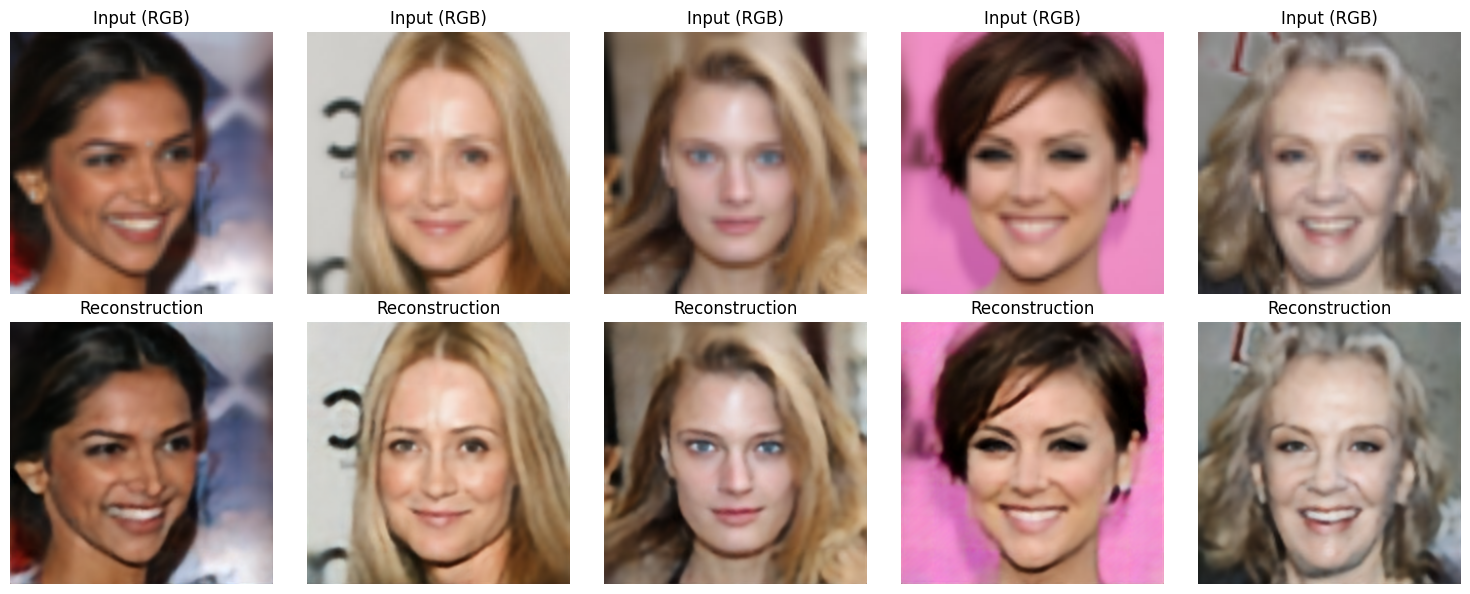

In [19]:
import torch
import matplotlib.pyplot as plt

def evaluate_validation_samples(model, val_loader, num_samples: int = 5):
    """
    Take a batch from val_loader (which may have 9-channel inputs: RGB + FFT), run the model on the
    first `num_samples` inputs, and display a matplotlib grid of RGB inputs vs. model outputs.
    """
    model.eval()
    # Grab one batch
    batch = next(iter(val_loader))
    inp_batch = batch["inp"]  # [B, C_in, H, W], C_in=9 if FFT was added

    # Move to same device as model
    device = next(model.parameters()).device
    inp_batch = inp_batch.to(device)

    # Run inference
    with torch.no_grad():
        recon_batch = model(inp_batch)  # [B, 3, H, W]

    # Bring tensors to CPU
    inp_batch = inp_batch.cpu()
    recon_batch = recon_batch.cpu()

    # Determine how many to show
    n = min(num_samples, inp_batch.size(0))

    # Plot grid: 2 rows (input, output) × n columns
    fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
    for i in range(n):
        # Extract only the first 3 channels (RGB) of the input
        rgb_in = inp_batch[i][:3]  # shape [3, H, W]

        # Convert to H×W×3 for plotting
        img_in = rgb_in.permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_in)
        axes[0, i].set_title("Input (RGB)")
        axes[0, i].axis("off")

        # Reconstruction
        img_out = recon_batch[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(img_out)
        axes[1, i].set_title("Reconstruction")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


# Usage example (after training):
evaluate_validation_samples(model, val_loader, num_samples=5)
